# PyMVPD Tutorial

This is a tutorial of how to perform MultiVariate Pattern Dependence (MVPD) analysis using the PyMVPD toolbox. The tutorial will walk you through analysis specification, data loading and finally analysis execution.

## Requirement Verification

Before using PyMVPD, make sure that you have PyTorch installed. To verify the installation of PyTorch, you can run the following sample PyTorch code to construct a randomly initialized tensor. The output should be something similar to "tensor([0.3277])".

In [1]:
import torch
x = torch.rand(1)
print(x)

tensor([0.5324])


A variety of pre-implemented MVPD models are provided in PyMVPD, including linear regression models and artificial neural networks. To train the MVPD neural network models efficiently, we highly recommend you to use GPUs, which allow for better computation of multiple parallel processes. Otherwise it might take a fairly long time to get the training results, especially when your neural network is large-scale involving a huge number of parameters.

To check if your system has an Nvidia GPU and if it is CUDA enabled, test with the following code:

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
else:
    print("No CUDA GPU detected!")

Using device: cuda
Tesla V100-SXM2-16GB


## MVPD Analysis

In [3]:
import os, sys
sys.path.append("..")
from mvpd import data_loading, model_exec

## Step 1 - Analysis Specification

The first step of MVPD analysis is to specify the following details:

the participant whose data are to be analyzed ('sub');

the total number of experimental runs ('total_run'); 

the paths to the directories containing processed functional data (‘filepath_func’);

the paths to the directories containing the predictor ROI mask (‘filepath_mask1’) and the target ROI mask (‘filepath_mask2’); 

the path to the directory where the extracted functional data will be saved (‘roidata_save_dir’); 

the path to the directory where the results will be saved (‘results_save_dir’); 

the type of model to be used (‘model_type’);

the option to save predicted timecourses (‘save_prediction’);

the model hyperparameters.

In [4]:
# Subject/Participant
sub='sub-01'
# Total number of experimental runs
total_run=8

In [5]:
# Functional Data
filepath_func=[]
filepath_func+=['./testdata/sub-01/sub-01_movie_bold_space-MNI152NLin2009cAsym_preproc_denoised_run1.nii.gz']
filepath_func+=['./testdata/sub-01/sub-01_movie_bold_space-MNI152NLin2009cAsym_preproc_denoised_run2.nii.gz']
filepath_func+=['./testdata/sub-01/sub-01_movie_bold_space-MNI152NLin2009cAsym_preproc_denoised_run3.nii.gz']
filepath_func+=['./testdata/sub-01/sub-01_movie_bold_space-MNI152NLin2009cAsym_preproc_denoised_run4.nii.gz']
filepath_func+=['./testdata/sub-01/sub-01_movie_bold_space-MNI152NLin2009cAsym_preproc_denoised_run5.nii.gz']
filepath_func+=['./testdata/sub-01/sub-01_movie_bold_space-MNI152NLin2009cAsym_preproc_denoised_run6.nii.gz']
filepath_func+=['./testdata/sub-01/sub-01_movie_bold_space-MNI152NLin2009cAsym_preproc_denoised_run7.nii.gz']
filepath_func+=['./testdata/sub-01/sub-01_movie_bold_space-MNI152NLin2009cAsym_preproc_denoised_run8.nii.gz']

In [6]:
# Predictor ROI Mask
filepath_mask1='./testdata/sub-01/sub-01_FFA_80vox_bin.nii.gz'
# Target ROI Mask
filepath_mask2='./testdata/GM_thr0.1_bin.nii.gz'

base1=os.path.basename(filepath_mask1)
base2=os.path.basename(filepath_mask2)
roi_1_name=base1.split('.nii')[0]
roi_2_name=base2.split('.nii')[0]

In [7]:
# Output Directory
roidata_save_dir='./testdata/roi_data/'
results_save_dir='./results/'

In [8]:
# MVPD Model
model_type='L2_LR' # ['PCA_LR', 'L2_LR', 'NN_1layer', 'NN_5layer', 'NN_5layer_dense']

In [9]:
# only for PCA_LR
num_pc=3 # number of principal components used 

# only for L2_LR
alpha=0.01 # regularization strength 

# only for neural networks (NN_1layer, NN_5layer, NN_5layer_dense)
input_size=80 # size of predictor ROI
output_size=53539 # size of target ROI
hidden_size=100 # number of units per hidden layer
num_epochs=5000 # number of epochs for training
save_freq=1000 # checkpoint saving frequency
print_freq=100 # results printing out frequency
batch_size=32 
learning_rate=1e-3
momentum_factor=0.9  
w_decay=0 # weight decay (L2 penalty)

In [10]:
# Save Data
save_prediction=False # default

## Step 2 - Data Loading

In [11]:
data_loading.load_data(sub, total_run, roi_1_name, roi_2_name, filepath_func, filepath_mask1, filepath_mask2, roidata_save_dir)

start loading data of sub-01
loading data in run 1
loading data in run 2
loading data in run 3
loading data in run 4
loading data in run 5
loading data in run 6
loading data in run 7
loading data in run 8
data loading done!


## Step 3 - Analysis Execution

In [12]:
model_exec.MVPD_exec(model_type, sub, total_run, 
                     alpha, num_pc, # reg params
                     input_size, output_size, hidden_size, num_epochs, save_freq, print_freq, batch_size, learning_rate, momentum_factor, w_decay, # nn params 
                     roidata_save_dir, roi_1_name, roi_2_name, filepath_func, filepath_mask1, filepath_mask2, results_save_dir, save_prediction)


start running L2_LR model for sub-01
test run: 1
test run: 2
test run: 3
test run: 4
test run: 5
test run: 6
test run: 7
test run: 8

average results across runs

done!


## Visualizing MVPD results

After running the MVPD model, you can visualize the results (e.g. average variance explained map across experimental runs) using a variety of visualization tools (e.g. Connectome Workbench, Mango, FSLeyes) and perform further statistical analyses.

In [26]:
import nibabel as nib
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

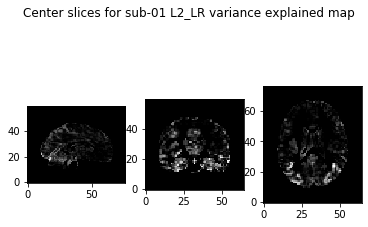

In [27]:
var_expl_img = nib.load(results_save_dir+sub+'_var_expl_map_'+model_type+'_avgruns.nii.gz')
var_expl_data = var_expl_img.get_fdata()
var_expl_shape = var_expl_data.shape;
x_center = var_expl_shape[0]//2;
y_center = var_expl_shape[1]//2;
z_center = var_expl_shape[2]//2;

show_slices([var_expl_data[x_center, :, :],
             var_expl_data[:, y_center, :],
             var_expl_data[:, :, z_center]])

plt.suptitle("Center slices for "+sub+" "+model_type+" variance explained map") 
plt.show()

Here are the example figures generated from our test runs (predictor ROI: FFA, target ROI: GM).

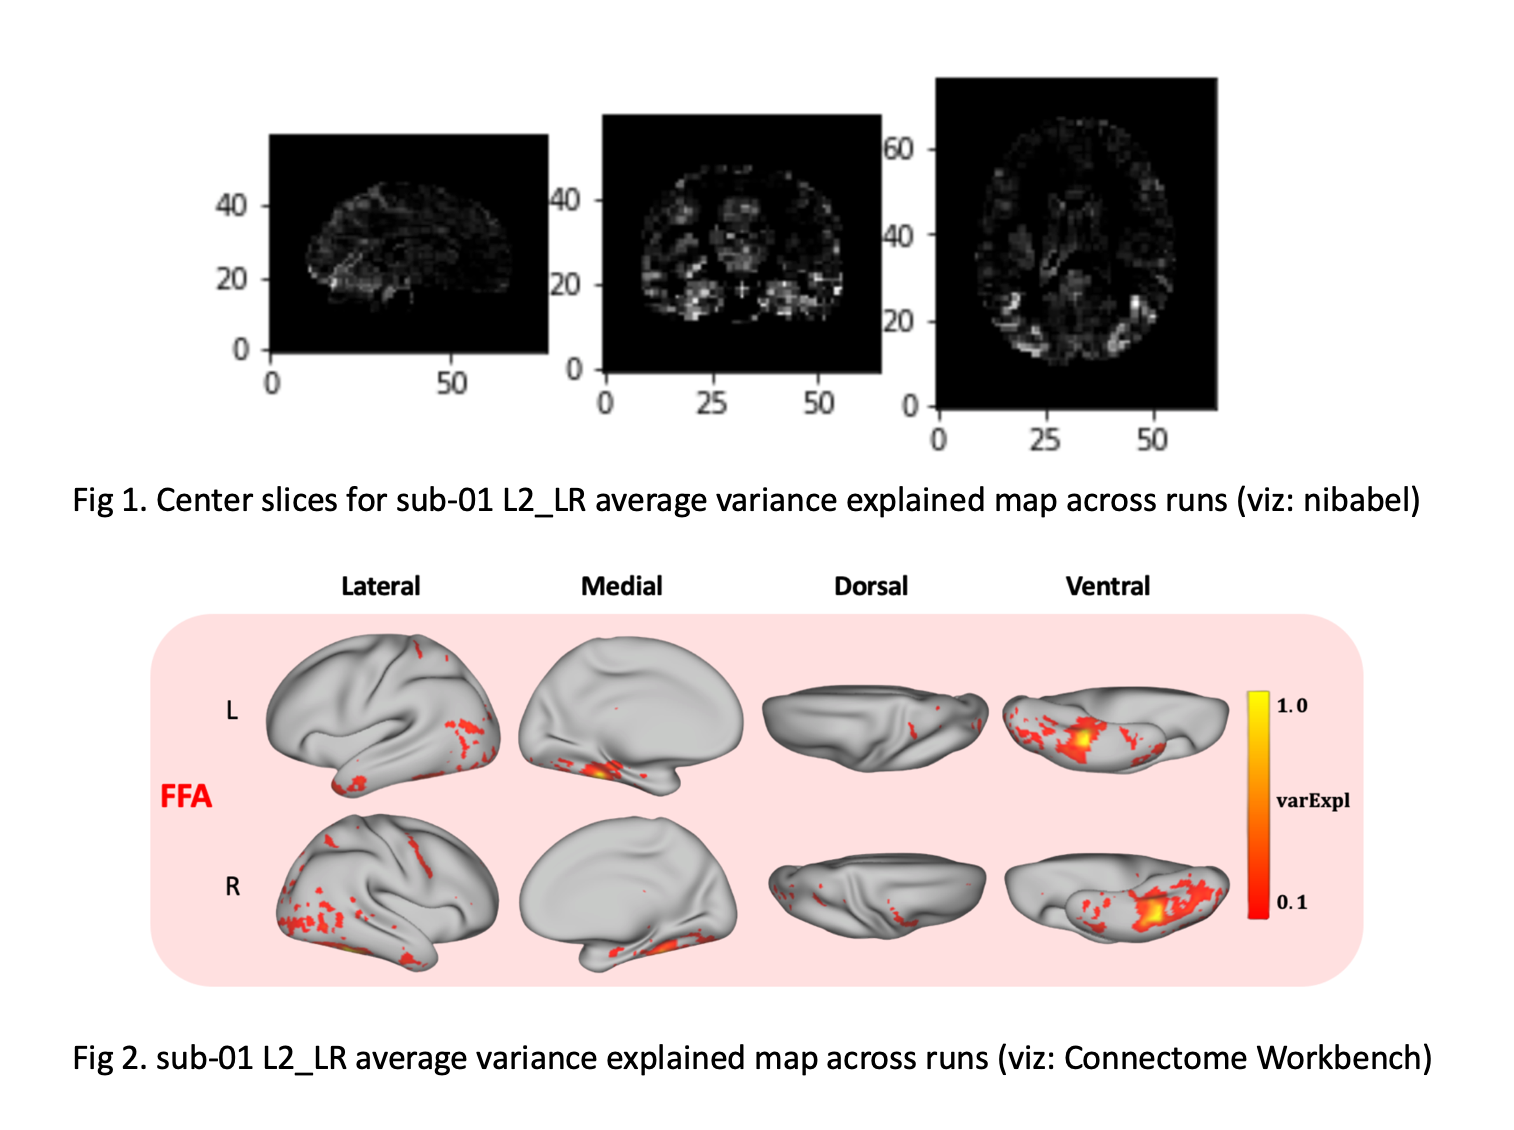

In [28]:
img_path='./example_viz_figures.png'
display(Image.open(img_path))